In [1]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [3]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.BinnedTestSetSplitter import BinnedTestSetSplitter
    from reservoir.BasicESNCuda import BasicESNCuda as BasicESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from binnedtestsetsplitter.binnedtestsetsplitter import BinnedTestSetSplitter
    from basicesncuda.basicesncuda import BasicESNCuda as BasicESN
    from esnutil.esnutil import generate_input_weights

In [4]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
if is_kaggle:
    data_path = '/kaggle/input/har70'
else:
    data_path = os.path.abspath(os.path.join('..', 'data'))

In [6]:
if not is_kaggle:
    # Download data
    downloader = DataDownloader()
    downloader.download_data('har70plus', data_path)

Dataset already downloaded


In [7]:
# Collect data into dataframes
collector = DataframeCollector()
collector.load_full_dataset(data_path + '/har70plus')

Discovered  18  csv files in  D:\Pycharm\COM6906-Dissertation\data/har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,record_num
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6,0
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6,1
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6,2
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6,3
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6,4
...,...,...,...,...,...,...,...,...,...
2259592,2021-06-11 11:13:14.098,-0.960693,-0.199951,-0.330566,-0.977051,0.006104,-0.246826,1,2259592
2259593,2021-06-11 11:13:14.118,-0.942627,-0.210205,-0.331543,-0.969482,0.004883,-0.231445,1,2259593
2259594,2021-06-11 11:13:14.138,-0.907227,-0.190918,-0.320312,-1.048096,0.067627,-0.234375,1,2259594
2259595,2021-06-11 11:13:14.159,-0.883057,-0.156982,-0.311279,-1.007080,0.063965,-0.248047,1,2259595


In [8]:
# The collector provides one large dataframe with all the data concatenated, and also an array of dataframes, one for each subject
dataframes = collector.get_dataframes()
full_data = collector.get_collected_data()

features = full_data[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'record_num', 'timestamp']]
labels = full_data['label']

test_split = 0.2
train_split = 1 - test_split
validation_split = 0.2

validation_from_train = True
use_slices = False

sampling_rate = 50
seconds_per_chunk = 10
required_chunks = sampling_rate * seconds_per_chunk

splitter = BinnedTestSetSplitter(test_size=test_split, val_size=validation_split, val_from_train=validation_from_train, seed=1234)

splitter.generate_splits(features, labels, chunk_size=required_chunks)

train_x, train_y, val_x, val_y, test_x, test_y = splitter.get_splits()

Chunks shape:  (4520, 500, 8)
Data shape:  (4520, 4000) (4520, 500)


In [9]:
# The (new) splitter provides the data as a numpy array, so we need to convert it back to a dataframe
train_x = pd.DataFrame(train_x, columns=features.columns)

# Set the index of the dataframe to be the record number
train_x.set_index('record_num', inplace=True)

# Check the shape of the dataframe
train_x.shape

(1446000, 7)

In [10]:
# Let's do the same for the validation data and the test data
val_x = pd.DataFrame(val_x, columns=features.columns)
val_x.set_index('record_num', inplace=True)

test_x = pd.DataFrame(test_x, columns=features.columns)
test_x.set_index('record_num', inplace=True)

val_x.shape, test_x.shape

((362000, 7), (452000, 7))

In [11]:
#And the labels also need to be converted back to a dataframe
train_y = pd.DataFrame(train_y, columns=['label'])
val_y = pd.DataFrame(val_y, columns=['label'])
test_y = pd.DataFrame(test_y, columns=['label'])    

In [12]:
# Get the unique labels
unique_labels = np.unique(train_y)

unique_labels

array([1, 3, 4, 5, 6, 7, 8], dtype=int64)

In [13]:
# Zeros appear to be showing up in the data, they shouldnt. Lets check what records they are in
train_y[train_y['label'] == 0]


,label


In [14]:
# Now we need to sort the dataframes by the record number
train_x.sort_index(inplace=True)
test_x.sort_index(inplace=True)
val_x.sort_index(inplace=True)

In [15]:
#Now that the data is sorted, we can remove the record number column and the timestamp column
train_x.drop(columns=['timestamp'], inplace=True)
test_x.drop(columns=['timestamp'], inplace=True)
val_x.drop(columns=['timestamp'], inplace=True)

In [16]:
# slice_size = 128
# slices_in_df_1 = len(collector.get_dataframes()[0]) // slice_size
# 
# print(len(train), len(val), len(test))

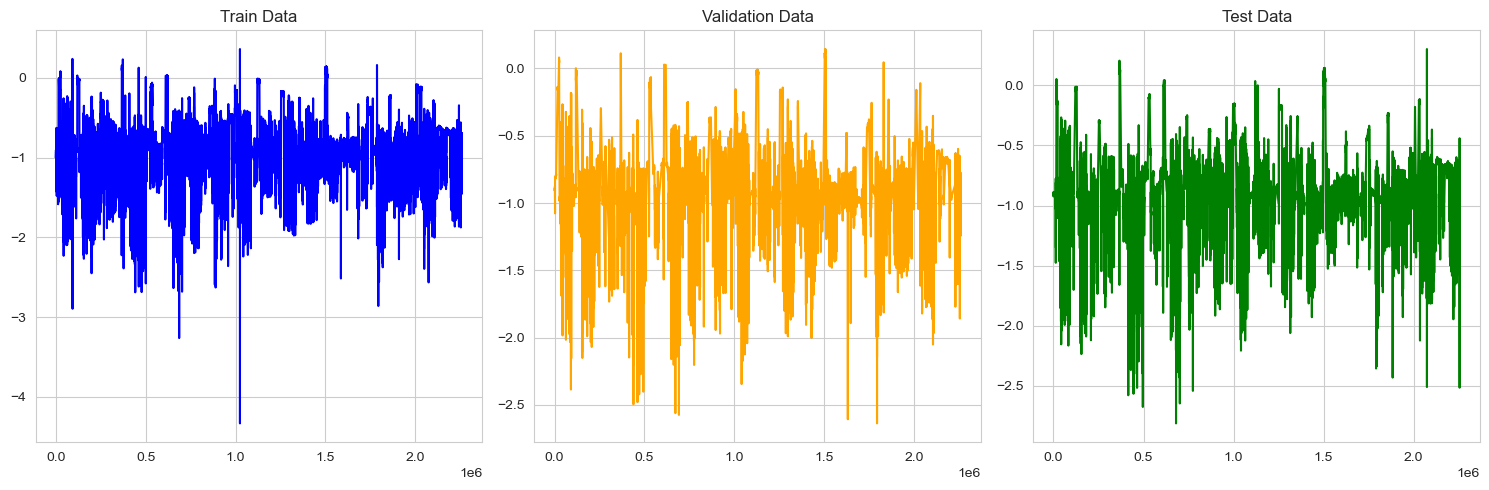

In [17]:
# Lets plot the data on a graph, colouring by whether it is train, val or test data
# Plot the column for back_x
plt.figure(figsize=(15, 5))
# if (use_slices):
#     train_slice = int(((slices_in_df_1 * train_split) * (1 - validation_split)) if validation_from_train else (slices_in_df_1 * (1 - test_split - validation_split)))
#     for i, df in enumerate(train[:train_slice]):
#         plt.plot(df['back_x'], label='Train', color='blue')
#     
#     val_slice = int((slices_in_df_1 * train_split) * validation_split) if validation_from_train else (slices_in_df_1 * validation_split)
#     for i, df in enumerate(val[:val_slice]):
#         plt.plot(df['back_x'], label='Val', color='orange')
#     
#     test_slice = int((slices_in_df_1 * test_split))
#     for i, df in enumerate(test[:test_slice]):
#         plt.plot(df['back_x'], label='Test', color='green')
#         
#     # Define a custom legend
#     from matplotlib.lines import Line2D
#     custom_lines = [Line2D([0], [0], color='blue', lw=2),
#                     Line2D([0], [0], color='orange', lw=2),
#                     Line2D([0], [0], color='green', lw=2)]
#     plt.legend(custom_lines, ['Train', 'Val', 'Test'])
# else:
#     plt.plot(train[0]['back_x'], label='Train', color='blue')
#     plt.plot(val[0]['back_x'], label='Val', color='orange')
#     plt.plot(test[0]['back_x'], label='Test', color='green')
#     plt.legend()

plt.subplot2grid((1, 3), (0, 0))
plt.plot(train_x['back_x'], label='Train', color='blue')
plt.title('Train Data')

plt.subplot2grid((1, 3), (0, 1))
plt.plot(val_x['back_x'], label='Val', color='orange')
plt.title('Validation Data')

plt.subplot2grid((1, 3), (0, 2))
plt.plot(test_x['back_x'], label='Test', color='green')
plt.title('Test Data')
    
# plt.title(f'Example of train, val and test data for one subject (back_x) using the properties (test_split={test_split}, val_split={validation_split}, val_from_train={validation_from_train}, use_slices={use_slices})')
plt.tight_layout()
plt.show()

In [18]:
# To use this ESN, we need to concatenate all of the training data into one large dataframe
#train_df = pd.concat(train)

In [19]:
# Check the shape of the dataframe
#train_df.shape
train_x.shape

(1446000, 6)

In [20]:
# Let's split the data into input and output, where the input is the 6 columns ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z'] and the output is the label column 'label'
# input_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
# output_columns = ['label']
# 
# X_train = train_df[input_columns].values
# y_train = train_df[output_columns].values

train_x.shape, train_y.shape

((1446000, 6), (1446000, 1))

In [21]:
# The label can be one of 7 values, so we need to one-hot encode it
from sklearn.preprocessing import OneHotEncoder

# The 7 values it can be are [1,3,4,5,6,7,8]

# Create the encoder
encoder = OneHotEncoder(categories='auto')

# Fit the encoder to the labels
encoder.fit(train_y)

# Transform the labels
y_train = encoder.transform(train_y).toarray()

# Check the shape of the one-hot encoded labels
y_train.shape


(1446000, 7)

In [22]:
# Get the first few rows of the one-hot encoded labels
y_train[:5]

array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [23]:
# The x data should be normalised to between -1 and 1
from sklearn.preprocessing import MinMaxScaler

# Create the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the data
scaler.fit(train_x)

# Transform the data
X_train = scaler.transform(train_x)

# Check the shape of the normalised data
X_train.shape

(1446000, 6)

In [24]:
# Get the first few rows of the normalised data
X_train[:5]

array([[ 0.419942  ,  0.09074898,  0.38619156,  0.22898885, -0.10051939,
         0.30693275],
       [ 0.42794747,  0.0819516 ,  0.38619156,  0.23239371, -0.10236891,
         0.30629848],
       [ 0.44073629,  0.08357592,  0.38619156,  0.23446254, -0.09440128,
         0.30363444],
       [ 0.43876069,  0.09318546,  0.38604736,  0.23304018, -0.08771438,
         0.3064677 ],
       [ 0.43127478,  0.1021181 ,  0.38749002,  0.22959225, -0.08335118,
         0.31065403]])

In [44]:
# Now we need to create the ESN

# We can star by defining the input weights for the data

# To do this, we will create a matrix of shape (n_neurons, n_features) where n_neurons is the number of neurons in the reservoir and n_features is the number of features in the input signal
# We will then populate this matrix from a density function where elements are 1 for a value p, and 0 for a value of 1-p
# This will give us a sparse matrix with a density of p

n_features = 6
density = 0.9
n_neurons = 500

# Generate the input weights
input_weights = np.random.rand(n_neurons, n_features) < density

# Check the shape of the input weights
print(input_weights.shape)



(500, 6)


In [45]:
# Next, we initialise the ESN
# We will use the BasicESN class from the reservoir.BasicESN module

leakage_rate = 0.9
spectral_radius = 0.9
gamma = 1.0
sparsity = 0.9
W_in = input_weights

esn = BasicESN(leakage_rate=leakage_rate, spectral_radius=spectral_radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in, sparsity=sparsity)

[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.9, spectral_radius: 0.9, gamma: 1.0, n_neurons: 500, sparsity: 0.9


In [46]:
# Now we need to train the ESN
# We will train the ESN using the training data

# As a test, lets only take the first 1000 samples
n_samples = 500000
data_in = X_train
data_out = y_train

esn.fit(data_in, data_out)


1450000it [10:34, 2285.47it/s]                             


Shape of previous_states: (1446000, 500)
Reservoir state computed, fitting readout layer...
Readout layer fitted.


In [47]:
# Now we can use the ESN to predict the output for the test data

# First we need to concatenate the test data into one large dataframe
# test_df = pd.concat(test)
# 
# # Check the shape of the dataframe
# test_df.shape

In [48]:
# Split the data into input and output
# X_test = test_df[input_columns].values
# y_test = test_df[output_columns].values

# One-hot encode the labels
y_test = encoder.transform(test_y).toarray()

# Normalise the input data
X_test = scaler.transform(test_x)

# Check the shape of the data
X_test.shape, y_test.shape

((452000, 6), (452000, 7))

In [49]:
# Get the first few rows of the data
X_test[:5], y_test[:5]

(array([[ 0.45290079,  0.10861482,  0.50624063,  0.23381606, -0.08178605,
          0.33150096],
        [ 0.45934716,  0.10861482,  0.50624063,  0.23381606, -0.08178605,
          0.3314587 ],
        [ 0.45945107,  0.10861482,  0.50624063,  0.23381606, -0.08178605,
          0.33162774],
        [ 0.45955498,  0.10861482,  0.50595222,  0.23381606, -0.08178605,
          0.33437648],
        [ 0.45924325,  0.10861482,  0.49700609,  0.23381606, -0.08178605,
          0.33420726]]),
 array([[0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0.]]))

In [50]:
# Now we can use the ESN to predict the output for the test data
y_pred = esn.forward(X_test)

# Check the shape of the predicted output
y_pred.shape


460000it [03:18, 2314.53it/s]                            


Shape of previous_states: (452000, 500)


(452000, 7)

In [51]:
# Get the first few rows of the predicted output
y_pred[:5]

array([[ 3.5489851e-01,  4.6705708e-02, -2.7981985e-02, -1.5182251e-02,
         7.4103570e-01, -7.1805632e-01,  6.1856818e-01],
       [ 1.3000512e-01,  2.1258235e-02, -1.9325506e-02, -9.6453615e-03,
         5.0389349e-01, -3.3737713e-01,  7.1117949e-01],
       [-4.0301919e-02,  2.3575127e-03, -1.2090158e-02, -4.9641598e-03,
         2.9688710e-01, -3.2566309e-02,  7.9067129e-01],
       [-1.6216600e-01, -1.0711223e-02, -6.0286038e-03, -1.0081902e-03,
         1.1899626e-01,  2.0242059e-01,  8.5848773e-01],
       [-2.4404788e-01, -1.9282967e-02, -9.0892240e-04,  2.2927690e-03,
        -3.1471014e-02,  3.7551308e-01,  9.1789728e-01]], dtype=float32)

In [52]:
# The predicted output is a one-hot encoded array, so we need to decode it back to the original labels
y_pred_decoded = encoder.inverse_transform(y_pred)

# Check the shape of the decoded output
y_pred_decoded.shape

(452000, 1)

In [53]:
# Get the first few rows of the decoded output
y_pred_decoded[:5]

array([[6],
       [8],
       [8],
       [8],
       [8]], dtype=int64)

In [54]:
y_test_decoded = encoder.inverse_transform(y_test)

# Check the shape of the decoded output
y_test_decoded.shape

(452000, 1)

In [55]:
y_test_decoded[:5]

array([[7],
       [7],
       [7],
       [7],
       [7]], dtype=int64)

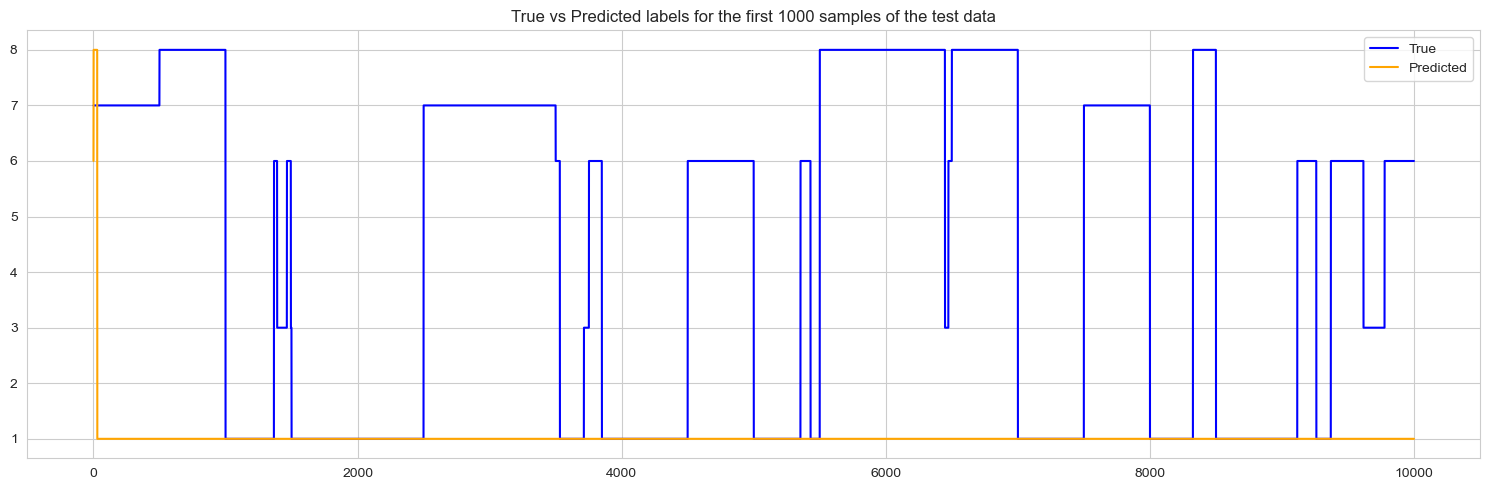

In [56]:
# Now we can evaluate the accuracy of the ESN on the test data
# Start by plotting the true label and the predicted label on a graph
plt.figure(figsize=(15, 5))
plt.plot(y_test_decoded[:10000], label='True', color='blue')
plt.plot(y_pred_decoded[:10000], label='Predicted', color='orange')
plt.legend()
plt.title('True vs Predicted labels for the first 1000 samples of the test data')

plt.tight_layout()
plt.show()

In [57]:
# Now we can calculate the accuracy of the ESN on the test data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_decoded, y_pred_decoded)

accuracy

0.49326106194690267

In [58]:
# Now we can calculate the confusion matrix for the ESN on the test data
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

conf_matrix

array([[221414,      0,      0,      0,    181,   1729,     12],
       [ 11585,      0,      0,      0,     47,    108,     79],
       [  1304,      0,      0,      0,      0,      0,      0],
       [  1527,      0,      0,      0,      0,      0,      0],
       [ 78326,      0,      0,      0,      8,   1016,      0],
       [ 92419,      0,      0,      0,      1,   1532,     51],
       [ 40579,      0,      0,      0,      0,     82,      0]],
      dtype=int64)

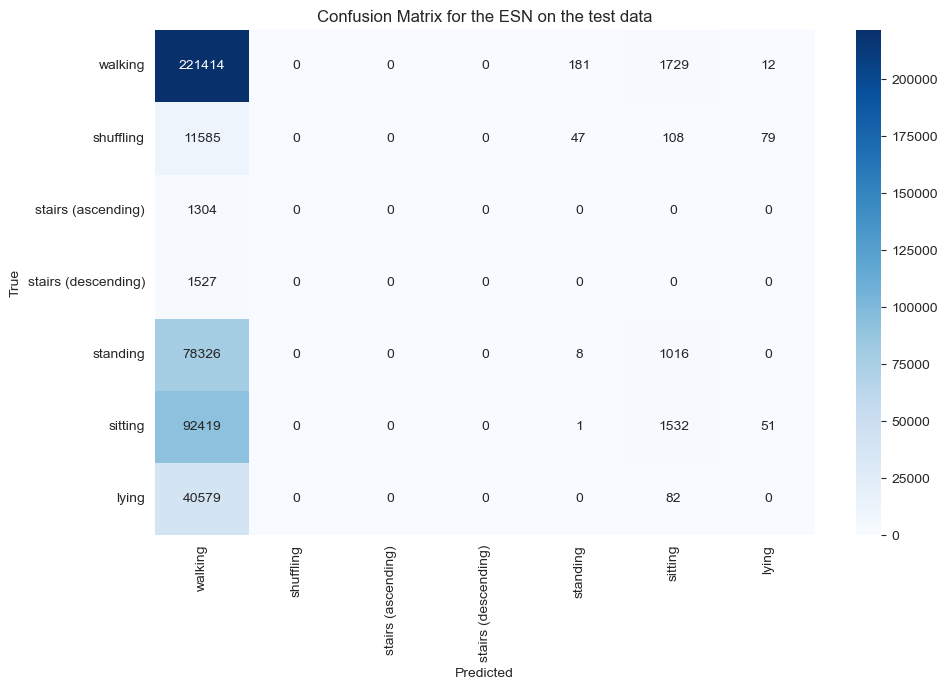

In [59]:
# Now we can plot the confusion matrix
# Our labels are 
# 1: walking	
# 3: shuffling
# 4: stairs (ascending)
# 5: stairs (descending)
# 6: standing
# 7: sitting
# 8: lying
# So we will use these labels for the x and y axis of the confusion matrix
import seaborn as sns

labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for the ESN on the test data')

plt.tight_layout()
plt.show()


In [60]:
# Now we can calculate the precision, recall and f1-score for the ESN on the test data
from sklearn.metrics import classification_report

report = classification_report(y_test_decoded, y_pred_decoded, target_names=labels)

print(report)

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

            walking       0.50      0.99      0.66    223336
          shuffling       0.00      0.00      0.00     11819
 stairs (ascending)       0.00      0.00      0.00      1304
stairs (descending)       0.00      0.00      0.00      1527
           standing       0.03      0.00      0.00     79350
            sitting       0.34      0.02      0.03     94003
              lying       0.00      0.00      0.00     40661

           accuracy                           0.49    452000
          macro avg       0.12      0.14      0.10    452000
       weighted avg       0.32      0.49      0.33    452000



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
# Now, we prepare the validation data
# val_df = pd.concat(val)
# 
# X_val = val_df[input_columns].values
# y_val = val_df[output_columns].values

y_val = encoder.transform(val_y).toarray()

X_val = scaler.transform(val_x)

X_val.shape, y_val.shape

((362000, 6), (362000, 7))

In [62]:
y_val_decoded = encoder.inverse_transform(y_val)

In [121]:
run_radii = False

In [122]:
# Now that there is a working version, we can optimise the hyperparameters
from sklearn.metrics import mean_squared_error

# The number of neurons will be fixed at 500
n_neurons = 500

density = 0.1
leakage_rate = 0.3
spectral_radius = 0.9
gamma = 1.
sparsity = 0.1

input_weights = np.random.rand(n_neurons, n_features) < density
W_in = input_weights

# We will first try to optimise the spectral radius
# In our implementation, the spectral radius is used to scale the reservoir weights
# It is a value between 0 and 1
# A value of 1 will mean that the reservoir weights are not scaled
# A value of 0 will mean that the reservoir weights are all 0
rseed = 1234
spectral_radii = [0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# We will train the ESN on the training data and evaluate it on the validation data
radii_scores = []
if run_radii:
    # There are 12 spectral radii to test, so let's parallelise the process
    def evaluate_spectral_radius(radius):
        esn = BasicESN(leakage_rate=leakage_rate, spectral_radius=radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in, sparsity=sparsity, is_optimising=False)
        esn.fit(data_in, data_out)
    
        y_pred = esn.forward(X_val)
        y_pred_decoded = encoder.inverse_transform(y_pred)
    
        # Calculate the NRMSE
        # The NRMSE is the normalised root mean squared error
        # It is calculated as the RMSE divided by the range of the true values
    
        nrmse = np.sqrt(mean_squared_error(y_val_decoded, y_pred_decoded)) / (y_val_decoded.max() - y_val_decoded.min())
    
        radii_scores.append(nrmse)
    
        # Return the radius and the NRMSE via joblib
        print(f'Spectral Radius: {radius}, NRMSE: {nrmse}')
        
        return {'radius': radius, 'nrmse': nrmse}
    
    #with tqdm_joblib(tqdm(desc="Spectral Radius", total=len(spectral_radii))) as progress_bar:
        #results = Parallel(n_jobs=4)(delayed(evaluate_spectral_radius)(radius) for radius in spectral_radii)
    results = []
    for radius in spectral_radii:
        print(f'Running for radius: {radius}')
        results.append(evaluate_spectral_radius(radius))
else:
    # Previously run results so that we don't need to re-run the optimisation process
    results = [{'radius': 0.005, 'nrmse': 0.5853647857997589}, {'radius': 0.05, 'nrmse': 0.5853647857997589}, {'radius': 0.1, 'nrmse': 0.5853722579885483}, {'radius': 0.2, 'nrmse': 0.5853844061176998}, {'radius': 0.3, 'nrmse': 0.5854029652726788}, {'radius': 0.4, 'nrmse': 0.5856335317893582}, {'radius': 0.5, 'nrmse': 0.585374523730174}, {'radius': 0.6, 'nrmse': 0.5854994151984787}, {'radius': 0.7, 'nrmse': 0.5852805604040272}, {'radius': 0.8, 'nrmse': 0.5850737300892936}, {'radius': 0.9, 'nrmse': 0.5848970779861485}, {'radius': 0.95, 'nrmse': 0.5847869690487514}]

In [123]:
print(results)

[{'radius': 0.005, 'nrmse': 0.5853647857997589}, {'radius': 0.05, 'nrmse': 0.5853647857997589}, {'radius': 0.1, 'nrmse': 0.5853722579885483}, {'radius': 0.2, 'nrmse': 0.5853844061176998}, {'radius': 0.3, 'nrmse': 0.5854029652726788}, {'radius': 0.4, 'nrmse': 0.5856335317893582}, {'radius': 0.5, 'nrmse': 0.585374523730174}, {'radius': 0.6, 'nrmse': 0.5854994151984787}, {'radius': 0.7, 'nrmse': 0.5852805604040272}, {'radius': 0.8, 'nrmse': 0.5850737300892936}, {'radius': 0.9, 'nrmse': 0.5848970779861485}, {'radius': 0.95, 'nrmse': 0.5847869690487514}]


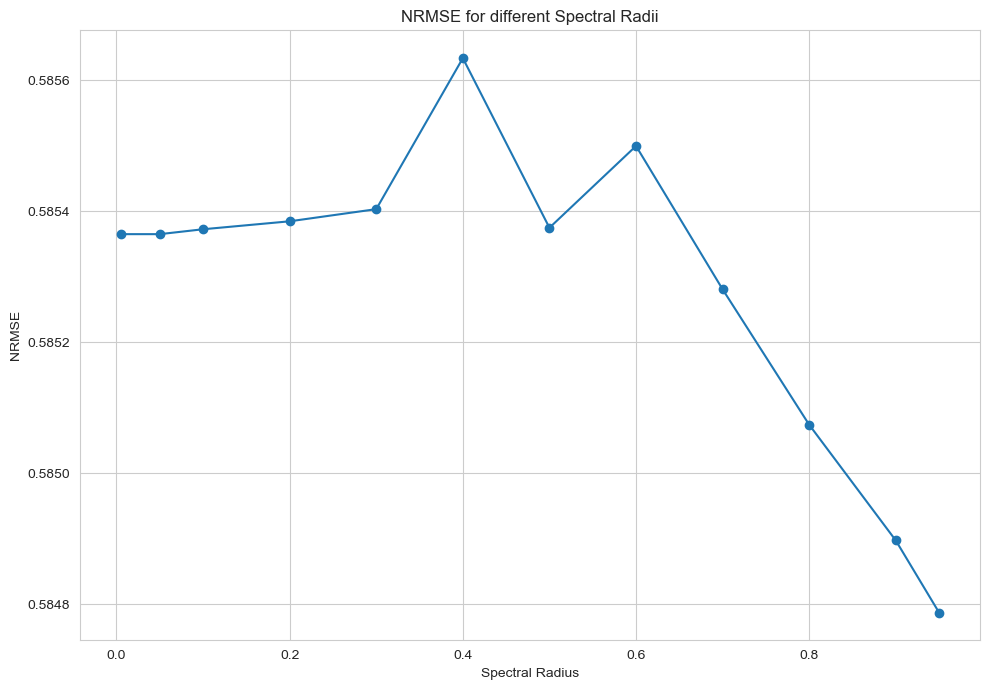

In [124]:
# Now we can plot the NRMSE for each spectral radius
radii = [result['radius'] for result in results]
nrmse = [result['nrmse'] for result in results]

plt.figure(figsize=(10, 7))
plt.plot(radii, nrmse, marker='o')

plt.xlabel('Spectral Radius')
plt.ylabel('NRMSE')
plt.title('NRMSE for different Spectral Radii')

plt.tight_layout()
plt.show()

In [125]:
# Get the best spectral radius
best_radius = results[np.argmin(nrmse)]['radius']

print(f'Best Spectral Radius: {best_radius}')

Best Spectral Radius: 0.95


In [126]:
run_leakage = False

In [127]:
# Now that there is a working version, we can optimise the hyperparameters
from sklearn.metrics import mean_squared_error

# The number of neurons will be fixed at 500
n_neurons = 500

density = 0.1
leakage_rate = 0.3
spectral_radius = 0.95
gamma = 1.
sparsity = 0.1

input_weights = np.random.rand(n_neurons, n_features) < density
W_in = input_weights

# Now we will optimise the leakage rate
# The leakage rate is a value between 0 and 1 and is used to determine how much of the previous state of the reservoir is retained
# A value of 0 will mean that none of the previous state is retained
# A value of 1 will mean that all of the previous state is retained and no new information is added
leakage_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

# We will train the ESN on the training data and evaluate it on the validation data
leakage_scores = []

if run_leakage:
    # There are 13 leakage rates to test, so let's parallelise the process
    def evaluate_leakage_rate(rate):
        esn = BasicESN(leakage_rate=rate, spectral_radius=spectral_radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in, sparsity=sparsity, is_optimising=False)
        esn.fit(data_in, data_out)
        
        y_pred = esn.forward(X_val)
        
        y_pred_decoded = encoder.inverse_transform(y_pred)
        
        # Calculate the NRMSE
        # The NRMSE is the normalised root mean squared error
        # It is calculated as the RMSE divided by the range of the true values
        
        nrmse = np.sqrt(mean_squared_error(y_val_decoded, y_pred_decoded)) / (y_val_decoded.max() - y_val_decoded.min())
        
        leakage_scores.append(nrmse)
        
        # Return the rate and the NRMSE via joblib
        print(f'Leakage Rate: {rate}, NRMSE: {nrmse}')
        
        return {'rate': rate, 'nrmse': nrmse}
    
    # with tqdm_joblib(tqdm(desc="Leakage Rate", total=len(leakage_rates))) as progress_bar:
    #     results = Parallel(n_jobs=4)(delayed(evaluate_leakage_rate)(rate) for rate in leakage_rates)
    results = []
    for rate in leakage_rates:
        print(f'Running for rate: {rate}')
        results.append(evaluate_leakage_rate(rate))
else:
    #results = [{'rate': 0.01, 'nrmse': 0.25124190818488}, {'rate': 0.05, 'nrmse': 0.2681906893923783}, {'rate': 0.1, 'nrmse': 0.26706317039377186}, {'rate': 0.2, 'nrmse': 0.24336720609682508}, {'rate': 0.3, 'nrmse': 0.24555088370120406}, {'rate': 0.4, 'nrmse': 0.2319308621095861}, {'rate': 0.5, 'nrmse': 0.22497402886748671}, {'rate': 0.6, 'nrmse': 0.20125566822625374}, {'rate': 0.7, 'nrmse': 0.19946100171160389}, {'rate': 0.8, 'nrmse': 0.19053586646013923}, {'rate': 0.9, 'nrmse': 0.1741566448003967}, {'rate': 0.95, 'nrmse': 0.18456934433880887}, {'rate': 0.99, 'nrmse': 0.19656424015426976}]
    results = [{'rate': 0.01, 'nrmse': 0.5848190581494312}, {'rate': 0.05, 'nrmse': 0.5847409313840034}, {'rate': 0.1, 'nrmse': 0.5848642694280468}, {'rate': 0.2, 'nrmse': 0.5847439234597631}, {'rate': 0.3, 'nrmse': 0.5847674251998481}, {'rate': 0.4, 'nrmse': 0.5849034464929598}, {'rate': 0.5, 'nrmse': 0.5845712749461299}, {'rate': 0.6, 'nrmse': 0.5846512102576803}, {'rate': 0.7, 'nrmse': 0.584546365332783}, {'rate': 0.8, 'nrmse': 0.5845145509302848}, {'rate': 0.9, 'nrmse': 0.5849402087904814}, {'rate': 0.95, 'nrmse': 0.5847656396798547}, {'rate': 0.99, 'nrmse': 0.5806604040885573}]


Running for rate: 0.01
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.01, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [11:22, 2123.01it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.64358e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:40, 2309.41it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.01, NRMSE: 0.5848190581494312
Running for rate: 0.05
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.05, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [10:59, 2197.29it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.27374e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:47, 2208.23it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.05, NRMSE: 0.5847409313840034
Running for rate: 0.1
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.1, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [10:53, 2217.82it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.09947e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:46, 2221.73it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.1, NRMSE: 0.5848642694280468
Running for rate: 0.2
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.2, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [10:42, 2257.38it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.47438e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:48, 2200.89it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.2, NRMSE: 0.5847439234597631
Running for rate: 0.3
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.3, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [10:28, 2307.41it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.77548e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:46, 2219.36it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.3, NRMSE: 0.5847674251998481
Running for rate: 0.4
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.4, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [10:55, 2211.47it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.21264e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:50, 2173.66it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.4, NRMSE: 0.5849034464929598
Running for rate: 0.5
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.5, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [11:03, 2185.43it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.70486e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:52, 2147.67it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.5, NRMSE: 0.5845712749461299
Running for rate: 0.6
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.6, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [11:15, 2146.13it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.19898e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:45, 2233.53it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.6, NRMSE: 0.5846512102576803
Running for rate: 0.7
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.7, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [10:54, 2216.02it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.15089e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:44, 2254.66it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.7, NRMSE: 0.584546365332783
Running for rate: 0.8
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [10:57, 2205.30it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.94493e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:44, 2251.71it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.8, NRMSE: 0.5845145509302848
Running for rate: 0.9
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.9, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [11:02, 2189.04it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.18668e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:48, 2199.38it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.9, NRMSE: 0.5849402087904814
Running for rate: 0.95
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.95, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [10:59, 2197.74it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.09829e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:44, 2243.35it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.95, NRMSE: 0.5847656396798547
Running for rate: 0.99
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 1.0, n_neurons: 500, sparsity: 0.1


1450000it [11:36, 2080.72it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.2687e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:50, 2173.74it/s]                            


Shape of previous_states: (361600, 500)
Leakage Rate: 0.99, NRMSE: 0.5806604040885573


In [128]:
print(results)


[{'rate': 0.01, 'nrmse': 0.5848190581494312}, {'rate': 0.05, 'nrmse': 0.5847409313840034}, {'rate': 0.1, 'nrmse': 0.5848642694280468}, {'rate': 0.2, 'nrmse': 0.5847439234597631}, {'rate': 0.3, 'nrmse': 0.5847674251998481}, {'rate': 0.4, 'nrmse': 0.5849034464929598}, {'rate': 0.5, 'nrmse': 0.5845712749461299}, {'rate': 0.6, 'nrmse': 0.5846512102576803}, {'rate': 0.7, 'nrmse': 0.584546365332783}, {'rate': 0.8, 'nrmse': 0.5845145509302848}, {'rate': 0.9, 'nrmse': 0.5849402087904814}, {'rate': 0.95, 'nrmse': 0.5847656396798547}, {'rate': 0.99, 'nrmse': 0.5806604040885573}]


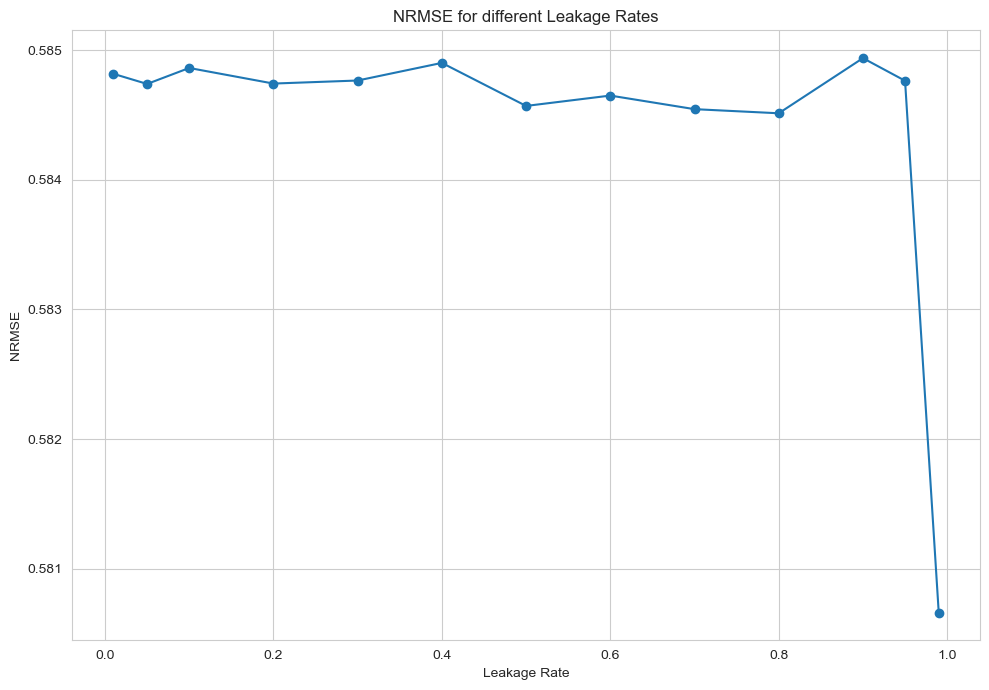

In [129]:
# Now we can plot the NRMSE for each leakage rate
rates = [result['rate'] for result in results]
nrmse = [result['nrmse'] for result in results]

plt.figure(figsize=(10, 7))
plt.plot(rates, nrmse, marker='o')
    
plt.xlabel('Leakage Rate')
plt.ylabel('NRMSE')
plt.title('NRMSE for different Leakage Rates')

plt.tight_layout()
plt.show()

In [130]:
# Get the best leakage rate
best_rate = results[np.argmin(nrmse)]['rate']

print(f'Best Leakage Rate: {best_rate}')

Best Leakage Rate: 0.99


In [131]:
run_gamma = True

In [132]:
# Now we can optimise the gamma parameter
# The gamma parameter is used to scale the input weights
# It is a value between 0 and 1
# A value of 1 will mean that the input weights are not scaled
# A value of 0 will mean that the input weights are all 0

# The number of neurons will be fixed at 500
n_neurons = 500

density = 0.1
leakage_rate = best_rate
spectral_radius = best_radius
gamma = 1
sparsity = 0.1

input_weights = np.random.rand(n_neurons, n_features) < density

W_in = input_weights

# We will optimise the gamma parameter

gammas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

# We will train the ESN on the training data and evaluate it on the validation data
gamma_scores = []

if run_gamma:
    # There are 13 gamma values to test, so let's parallelise the process
    def evaluate_gamma(gamma):
        esn = BasicESN(leakage_rate=leakage_rate, spectral_radius=spectral_radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in, sparsity=sparsity, is_optimising=False)
        esn.fit(data_in, data_out)
        
        y_pred = esn.forward(X_val)
        
        y_pred_decoded = encoder.inverse_transform(y_pred)
        
        # Calculate the NRMSE
        # The NRMSE is the normalised root mean squared error
        # It is calculated as the RMSE divided by the range of the true values
        
        nrmse = np.sqrt(mean_squared_error(y_val_decoded, y_pred_decoded)) / (y_val_decoded.max() - y_val_decoded.min())
        
        gamma_scores.append(nrmse)
        
        # Return the gamma and the NRMSE via joblib
        print(f'Gamma: {gamma}, NRMSE: {nrmse}')
        
        return {'gamma': gamma, 'nrmse': nrmse}
    
    # with tqdm_joblib(tqdm(desc="Gamma", total=len(gammas))) as progress_bar:
    #     results = Parallel(n_jobs=4)(delayed(evaluate_gamma)(gamma) for gamma in gammas)
    results = []
    for gamma in gammas:
        print(f'Running for gamma: {gamma}')
        results.append(evaluate_gamma(gamma))
        
else:
    results = [{'gamma': 0.01, 'nrmse': 0.3349602855101908}, {'gamma': 0.05, 'nrmse': 0.33045212706131855}, {'gamma': 0.1, 'nrmse': 0.3290671066122628}, {'gamma': 0.2, 'nrmse': 0.29955513273731876}, {'gamma': 0.3, 'nrmse': 0.24673740826225551}, {'gamma': 0.4, 'nrmse': 0.22749927728185315}, {'gamma': 0.5, 'nrmse': 0.22418029881240797}, {'gamma': 0.6, 'nrmse': 0.2155434353574596}, {'gamma': 0.7, 'nrmse': 0.21459169317536275}, {'gamma': 0.8, 'nrmse': 0.19456340750175669}, {'gamma': 0.9, 'nrmse': 0.18447620141525248}, {'gamma': 0.95, 'nrmse': 0.18382599604128477}, {'gamma': 0.99, 'nrmse': 0.18044621192767088}]

Running for gamma: 0.01
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.01, n_neurons: 500, sparsity: 0.1


1450000it [11:01, 2190.98it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...
Readout layer fitted.


370000it [02:47, 2207.97it/s]                            


Shape of previous_states: (361600, 500)
Gamma: 0.01, NRMSE: 0.5854556025840681
Running for gamma: 0.05
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.05, n_neurons: 500, sparsity: 0.1


1450000it [11:02, 2188.37it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...
Readout layer fitted.


370000it [02:51, 2162.61it/s]                            


Shape of previous_states: (361600, 500)
Gamma: 0.05, NRMSE: 0.5840714797077347
Running for gamma: 0.1
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.1, n_neurons: 500, sparsity: 0.1


1450000it [11:04, 2182.98it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...
Readout layer fitted.


370000it [02:32, 2426.78it/s]                            


Shape of previous_states: (361600, 500)
Gamma: 0.1, NRMSE: 0.5843880969062177
Running for gamma: 0.2
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.2, n_neurons: 500, sparsity: 0.1


1450000it [11:03, 2186.96it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.71316e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:48, 2190.95it/s]                            


Shape of previous_states: (361600, 500)
Gamma: 0.2, NRMSE: 0.5850074073862375
Running for gamma: 0.3
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.3, n_neurons: 500, sparsity: 0.1


1450000it [11:11, 2160.76it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.24176e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:47, 2204.66it/s]                            


Shape of previous_states: (361600, 500)
Gamma: 0.3, NRMSE: 0.5859336046014636
Running for gamma: 0.4
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.4, n_neurons: 500, sparsity: 0.1


1450000it [11:21, 2128.51it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.09132e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [02:53, 2127.58it/s]                            


Shape of previous_states: (361600, 500)
Gamma: 0.4, NRMSE: 0.585580187618638
Running for gamma: 0.5
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.5, n_neurons: 500, sparsity: 0.1


1450000it [11:19, 2135.22it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.5413e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [03:02, 2031.20it/s]                            


Shape of previous_states: (361600, 500)
Gamma: 0.5, NRMSE: 0.5854421544903384
Running for gamma: 0.6
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.6, n_neurons: 500, sparsity: 0.1


1450000it [11:42, 2063.36it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.91343e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [03:04, 2006.64it/s]                            


Shape of previous_states: (361600, 500)
Gamma: 0.6, NRMSE: 0.5851278438450581
Running for gamma: 0.7
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.7, n_neurons: 500, sparsity: 0.1


1450000it [17:57, 1345.22it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.63658e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [03:13, 1908.23it/s]                            


Shape of previous_states: (361600, 500)
Gamma: 0.7, NRMSE: 0.5850239043537814
Running for gamma: 0.8
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.8, n_neurons: 500, sparsity: 0.1


1450000it [11:37, 2079.28it/s]                             


Shape of previous_states: (1446144, 500)
Reservoir state computed, fitting readout layer...


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.21605e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


370000it [03:13, 1916.53it/s]                            


Shape of previous_states: (361600, 500)
Gamma: 0.8, NRMSE: 0.5834327480066849
Running for gamma: 0.9
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.9, n_neurons: 500, sparsity: 0.1


  6%|▌         | 80000/1446144 [00:36<10:18, 2207.91it/s] 


KeyboardInterrupt: 

In [ ]:
print(results)

In [ ]:
# Now we can plot the NRMSE for each gamma value
gammas = [result['gamma'] for result in results]
nrmse = [result['nrmse'] for result in results]

plt.figure(figsize=(10, 7))
plt.plot(gammas, nrmse, marker='o')

plt.xlabel('Gamma')
plt.ylabel('NRMSE')
plt.title('NRMSE for different Gamma values')

plt.tight_layout()
plt.show()

In [ ]:
# Get the best gamma value
best_gamma = results[np.argmin(nrmse)]['gamma']

print(f'Best Gamma: {best_gamma}')

In [ ]:
run_density = True

In [ ]:
# Now we can optimise the density parameter
# The density parameter is used to determine the sparsity of the input weights
# It is a value between 0 and 1
# A value of 1 will mean that all of the input weights are 1
# A value of 0 will mean that all of the input weights are 0

# The number of neurons will be fixed at 500
n_neurons = 500

density = 0.1
leakage_rate = best_rate
spectral_radius = best_radius
gamma = best_gamma
sparsity = 0.1

input_weights = np.random.rand(n_neurons, n_features) < density

W_in = input_weights

# We will optimise the density parameter

densities = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# We will train the ESN on the training data and evaluate it on the validation data
density_scores = []

if run_density:
    # There are 13 density values to test, so let's parallelise the process
    def evaluate_density(density):
        input_weights = np.random.rand(n_neurons, n_features) < density
        W_in = input_weights
        
        esn = BasicESN(leakage_rate=leakage_rate, spectral_radius=spectral_radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in,
                          sparsity=sparsity, is_optimising=True)
        esn.fit(data_in, data_out)
        
        y_pred = esn.forward(X_val)
        
        y_pred_decoded = encoder.inverse_transform(y_pred)
        
        # Calculate the NRMSE
        # The NRMSE is the normalised root mean squared error
        # It is calculated as the RMSE divided by the range of the true values
        
        nrmse = np.sqrt(mean_squared_error(y_val_decoded, y_pred_decoded)) / (y_val_decoded.max() - y_val_decoded.min())
        
        density_scores.append(nrmse)
        
        # Return the density and the NRMSE via joblib
        print(f'Density: {density}, NRMSE: {nrmse}')
        
        return {'density': density, 'nrmse': nrmse}
    
    # with tqdm_joblib(tqdm(desc="Density", total=len(densities))) as progress_bar:
    #     results = Parallel(n_jobs=4)(delayed(evaluate_density)(density) for density in densities)
    results = []
    for density in densities:
        print(f'Running for density: {density}')
        results.append(evaluate_density(density))
        
else:
    results = [{'density': 0.01, 'nrmse': 0.23353197949175228}, {'density': 0.05, 'nrmse': 0.21794291184600953}, {'density': 0.1, 'nrmse': 0.17650854637966737}, {'density': 0.2, 'nrmse': 0.1499906587161872}, {'density': 0.3, 'nrmse': 0.15278724892963502}, {'density': 0.4, 'nrmse': 0.13531609959415156}, {'density': 0.5, 'nrmse': 0.13072468336037607}, {'density': 0.6, 'nrmse': 0.14543399578391006}, {'density': 0.7, 'nrmse': 0.13741609370096877}, {'density': 0.8, 'nrmse': 0.14272817051782377}, {'density': 0.9, 'nrmse': 0.14367831433239842}, {'density': 0.95, 'nrmse': 0.14945441480562682}]

In [ ]:
print(results)

In [ ]:
# Now we can plot the NRMSE for each density value
densities = [result['density'] for result in results]
nrmse = [result['nrmse'] for result in results]

plt.figure(figsize=(10, 7))
plt.plot(densities, nrmse, marker='o')

plt.xlabel('Density')
plt.ylabel('NRMSE')
plt.title('NRMSE for different Density values')

plt.tight_layout()
plt.show()

In [ ]:
# Get the best density value
best_density = results[np.argmin(nrmse)]['density']

print(f'Best Density: {best_density}')

In [ ]:
run_neurons = False

In [ ]:
# Now we can optimise the number of neurons
# The number of neurons is the number of nodes in the reservoir

n_neurons = 500

density = best_density
leakage_rate = best_rate
spectral_radius = best_radius
gamma = best_gamma
sparsity = 0.1

input_weights = np.random.rand(n_neurons, n_features) < density

W_in = input_weights

# We will optimise the number of neurons

neurons = [100, 250, 500, 750, 1000]

# We will train the ESN on the training data and evaluate it on the validation data

neuron_scores = []

if run_neurons:
    # There are 5 neuron values to test, so let's parallelise the process
    def evaluate_neurons(n_neurons):
        input_weights = np.random.rand(n_neurons, n_features) < density
        W_in = input_weights
        
        esn = BasicESN(leakage_rate=leakage_rate, spectral_radius=spectral_radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in,
                            sparsity=sparsity, is_optimising=False)
        esn.fit(data_in, data_out)
        
        y_pred = esn.forward(X_val)
        
        y_pred_decoded = encoder.inverse_transform(y_pred)
        
        # Calculate the NRMSE
        # The NRMSE is the normalised root mean squared error
        # It is calculated as the RMSE divided by the range of the true values
        
        nrmse = np.sqrt(mean_squared_error(y_val_decoded, y_pred_decoded)) / (y_val_decoded.max() - y_val_decoded.min())
        
        neuron_scores.append(nrmse)
        
        # Return the number of neurons and the NRMSE via joblib
        print(f'Neurons: {n_neurons}, NRMSE: {nrmse}')
        
        return {'neurons': n_neurons, 'nrmse': nrmse}
    
    # with tqdm_joblib(tqdm(desc="Neurons", total=len(neurons))) as progress_bar:
    #     results = Parallel(n_jobs=5)(delayed(evaluate_neurons)(n_neurons) for n_neurons in neurons)
    results = []
    for n_neurons in neurons:
        print(f'Running for neurons: {n_neurons}')
        results.append(evaluate_neurons(n_neurons))
        
else:
    results = [{'neurons': 100, 'nrmse': 0.18322173124370597}, {'neurons': 250, 'nrmse': 0.15066900805978828}, {'neurons': 500, 'nrmse': 0.1361232530363811}, {'neurons': 750, 'nrmse': 0.12739381499580593}, {'neurons': 1000, 'nrmse': 0.12691977638276095}]

In [ ]:
print(results)

In [ ]:
# Now we can plot the NRMSE for each number of neurons

neurons = [result['neurons'] for result in results]
nrmse = [result['nrmse'] for result in results]

plt.figure(figsize=(10, 7))
plt.plot(neurons, nrmse, marker='o')

plt.xlabel('Number of Neurons')
plt.ylabel('NRMSE')

plt.title('NRMSE for different Number of Neurons')

plt.tight_layout()
plt.show()

In [ ]:
# Get the best number of neurons
best_neurons = results[np.argmin(nrmse)]['neurons']

print(f'Best Number of Neurons: {best_neurons}')

In [ ]:
# Looking at the graph, there is diminishing returns after 500 neurons, but to check, lets calculate the change in NRMSE for each number of neurons

# Calculate the change in NRMSE for each number of neurons as a percentage of the previous value
nrmse_change = [((nrmse[i] - nrmse[i-1]) / nrmse[i-1]) * 100 for i in range(1, len(nrmse))]

print(nrmse_change)

In [ ]:
# The difference between 1000 and 750 neurons is only 0.4%, so we will use less neurons to reduce computation time
# The best number of neurons is 750, however this leads to significant computation time
# We will use 500 neurons instead
best_neurons = 500

In [ ]:
run_weights = True

In [ ]:
# Next, we can try different input weight sampling methods
# The input weights are the weights between the input and the reservoir

n_neurons = best_neurons

density = best_density
leakage_rate = best_rate
spectral_radius = best_radius
gamma = best_gamma
sparsity = 0.1

input_weights = np.random.rand(n_neurons, n_features) < density

W_in = input_weights

# We will optimise the input weight sampling method

weight_methods = ['0/1', 'normal', 'uniform', '-1/1']

# We will train the ESN on the training data and evaluate it on the validation data
weight_scores = []

if run_weights:
    # There are 4 weight methods to test, so let's parallelise the process
    def evaluate_weight_method(method):
        # Let's set a seed for reproducibility
        np.random.seed(1234)
        
        if method == '0/1':
            input_weights = np.random.rand(n_neurons, n_features) < density
        elif method == 'normal':
            input_weights = np.random.normal(0, 1, (n_neurons, n_features))
        elif method == 'uniform':
            input_weights = np.random.uniform(-1, 1, (n_neurons, n_features))
        elif method == '-1/1':
            input_weights = np.random.uniform(-1, 1, (n_neurons, n_features)) < density
        
        W_in = input_weights
        
        esn = BasicESN(leakage_rate=leakage_rate, spectral_radius=spectral_radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in, sparsity=sparsity, is_optimising=False)
        esn.fit(data_in, data_out)
        
        y_pred = esn.forward(X_val)
        
        y_pred_decoded = encoder.inverse_transform(y_pred)
        
        # Calculate the NRMSE
        # The NRMSE is the normalised root mean squared error
        # It is calculated as the RMSE divided by the range of the true values
        
        nrmse = np.sqrt(mean_squared_error(y_val_decoded, y_pred_decoded)) / (y_val_decoded.max() - y_val_decoded.min())
        
        weight_scores.append(nrmse)
        
        # Return the method and the NRMSE via joblib
        print(f'Method: {method}, NRMSE: {nrmse}')
        
        return {'method': method, 'nrmse': nrmse}
    
    # with tqdm_joblib(tqdm(desc="Weight Method", total=len(weight_methods))) as progress_bar:
    #     results = Parallel(n_jobs=4)(delayed(evaluate_weight_method)(method) for method in weight_methods)
    results = []
    for method in weight_methods:
        print(f'Running for method: {method}')
        results.append(evaluate_weight_method(method))
        
else:
    results = [{'method': '0/1', 'nrmse': 0.14073219709693063}, {'method': 'normal', 'nrmse': 0.13132028435177762}, {'method': 'uniform', 'nrmse': 0.14063271688341764}, {'method': '-1/1', 'nrmse': 0.13572163315383687}]

In [ ]:
print(results)

In [ ]:
# Now we can plot the NRMSE for each weight method
methods = [result['method'] for result in results]
nrmse = [result['nrmse'] for result in results]

plt.figure(figsize=(10, 7))
plt.bar(methods, nrmse)

plt.xlabel('Weight Method')
plt.ylabel('NRMSE')
plt.title('NRMSE for different Weight Methods')

plt.tight_layout()
plt.show()

In [ ]:
# Get the best weight method
best_method = results[np.argmin(nrmse)]['method']

print(f'Best Weight Method: {best_method}')

In [ ]:
run_sparsity = True

In [ ]:
# Finally, we can optimise the sparsity parameter
# The sparsity parameter is used to determine the sparsity of the reservoir weights
# It is a value between 0 and 1
# A value of 1 will mean that all reservoir weights are connected
# A value of 0 will mean that no reservoir weights are connected

# The number of neurons will be fixed at 500
n_neurons = best_neurons

density = best_density
leakage_rate = best_rate
spectral_radius = best_radius
gamma = best_gamma
sparsity = 0.1

input_weights = generate_input_weights(n_neurons, n_features, density, best_method)

W_in = input_weights

# We will optimise the sparsity parameter

sparsities = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# We will train the ESN on the training data and evaluate it on the validation data
sparsity_scores = []

if run_sparsity:
    # There are 13 sparsity values to test, so let's parallelise the process
    def evaluate_sparsity(sparsity):
        esn = BasicESN(leakage_rate=leakage_rate, spectral_radius=spectral_radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in, sparsity=sparsity, is_optimising=False)
        
        esn.fit(data_in, data_out)
        
        y_pred = esn.forward(X_val)
        
        y_pred_decoded = encoder.inverse_transform(y_pred)
        
        # Calculate the NRMSE
        
        nrmse = np.sqrt(mean_squared_error(y_val_decoded, y_pred_decoded)) / (y_val_decoded.max() - y_val_decoded.min())
        
        sparsity_scores.append(nrmse)
        
        # Return the sparsity and the NRMSE via joblib
        print(f'Sparsity: {sparsity}, NRMSE: {nrmse}')
        
        return {'sparsity': sparsity, 'nrmse': nrmse}
    
    # with tqdm_joblib(tqdm(desc="Sparsity", total=len(sparsities))) as progress_bar:
    #     results = Parallel(n_jobs=4)(delayed(evaluate_sparsity)(sparsity) for sparsity in sparsities)
    results = []
    for sparsity in sparsities:
        print(f'Running for sparsity: {sparsity}')
        results.append(evaluate_sparsity(sparsity))
        
else:
    results = [{'sparsity': 0.01, 'nrmse': 0.13029135072379394}, {'sparsity': 0.05, 'nrmse': 0.13565649139847283}, {'sparsity': 0.1, 'nrmse': 0.13149778509577562}, {'sparsity': 0.2, 'nrmse': 0.1303334301330403}, {'sparsity': 0.3, 'nrmse': 0.13096549852897035}, {'sparsity': 0.4, 'nrmse': 0.12841601100974473}, {'sparsity': 0.5, 'nrmse': 0.1275029829269864}, {'sparsity': 0.6, 'nrmse': 0.1293289216233986}, {'sparsity': 0.7, 'nrmse': 0.13077851430315893}, {'sparsity': 0.8, 'nrmse': 0.12445118495281327}, {'sparsity': 0.9, 'nrmse': 0.1299768951059773}, {'sparsity': 0.95, 'nrmse': 0.130972372456204}]

In [ ]:
print(results)

In [ ]:
# Now we can plot the NRMSE for each sparsity value
sparsities = [result['sparsity'] for result in results]
nrmse = [result['nrmse'] for result in results]

plt.figure(figsize=(10, 7))
plt.plot(sparsities, nrmse, marker='o')

plt.xlabel('Sparsity')
plt.ylabel('NRMSE')
plt.title('NRMSE for different Sparsity values')

plt.tight_layout()
plt.show()

In [ ]:
# Get the best sparsity value
best_sparsity = results[np.argmin(nrmse)]['sparsity']

print(f'Best Sparsity: {best_sparsity}')

In [ ]:
from sklearn.utils import compute_class_weight

# Now that all the hyperparameters have been optimised, we can now apply them to the ESN, along with class weights
# The class weights are used to balance the classes in the training data

dataset = collector.get_collected_data()

labels = dataset['label'].values

# Calculate the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

# Print the class weight for each class and the labels

weight_map = {label: weight for label, weight in zip(np.unique(labels), class_weights)}

for label, weight in weight_map.items():
    print(f'Class: {label}, Weight: {weight}')
    

In [ ]:
# Now we can train the ESN on the training data with the optimised hyperparameters and the class weights
n_neurons = best_neurons

density = best_density
leakage_rate = best_rate
spectral_radius = best_radius
gamma = best_gamma
sparsity = best_sparsity

input_weights = generate_input_weights(n_neurons, n_features, density, best_method)

W_in = input_weights

esn = BasicESN(leakage_rate=leakage_rate, spectral_radius=spectral_radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in, sparsity=sparsity, class_weights=class_weights)

esn.fit(data_in, data_out, x_val=X_val, y_val=y_val)

In [ ]:
# Now we can evaluate the ESN on the test data
y_pred = esn.forward(X_test)

y_pred_decoded = encoder.inverse_transform(y_pred)

In [ ]:

accuracy = accuracy_score(y_test_decoded, y_pred_decoded)

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

# The labels are
# 1: walking
# 3: shuffling
# 4: stairs (ascending)
# 5: stairs (descending)
# 6: standing
# 7: sitting
# 8: lying
# So we will use these labels for the classification report
label_names = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

report = classification_report(y_test_decoded, y_pred_decoded, target_names=label_names)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix: {conf_matrix}')
print(f'Report: {report}')

In [ ]:
# Now we can plot the confusion matrix
plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for the ESN on the test data')
    
plt.tight_layout()
plt.show()

In [ ]:
# The confusion matrix is tricky to interpret, as there is a serious class imbalance
# To get a better idea of the performance of the ESN, we can plot the normalised confusion matrix
norm_conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))

sns.heatmap(norm_conf_matrix, annot=True, fmt='.2f', xticklabels=label_names, yticklabels=label_names, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Normalised Confusion Matrix for the ESN on the test data')

plt.tight_layout()
plt.show()

In [ ]:
# After looking at the normalised confusion matrix, we can see that the ESN is performing well on the test data, but there is room for improvement
# Especially in some of the classes with less data

In [ ]:
# Let's plot the ground truth and the predicted labels for the test data on two subplots

plt.figure(figsize=(25, 15))

plt.subplot2grid((2, 1), (0, 0))
plt.plot(y_test_decoded, label='True')
plt.title('True Labels')
plt.xlabel('Sample')

plt.subplot2grid((2, 1), (1, 0))
plt.plot(y_pred_decoded, label='Predicted')
plt.title('Predicted Labels')
plt.xlabel('Sample')

plt.tight_layout()
plt.show()

In [ ]:
# Pickle the ESN for later use in case we need to use it
import pickle

with open('basicESN_har70.pkl', 'wb') as f:
    pickle.dump(esn, f)